# Ordinal model

This messy notebook trains the XGboost model used in wikidit.

In [2]:
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2
import wikidit

In [3]:
from wikidit.preprocessing import _load_backlog, WP10_LABELS
from wikidit.io import read_labeled
from wikidit.ordinal import SequentialClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import (f1_score, roc_auc_score, accuracy_score, 
                             precision_score, recall_score, log_loss, 
                             confusion_matrix)
from sklearn.base import clone

In [4]:
import xgboost

In [5]:
xgboost.__version__

'0.80'

# Train Model

In [6]:
output_dir = "../data/enwiki-labeling_revisions-w_features/"
revisions = read_labeled(output_dir)

In [7]:
from sklearn.model_selection import train_test_split

In [54]:
from wikidit.models import RevisionPreprocessor

In [55]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
import xgboost as xgb
import dill
import itertools

response_col = ['wp10']

xgb_params = {
  'silent': True,
  'booster': 'gbtree',
  'objective': 'binary:logistic',
  'random_state': 12345,
  'learning_rate': 0.1,
  'n_estimators': 100,
  'min_child_weight': 1,
  'gamma': 0,
  'subsample': 1,
  'colsample_bytree': 1,
  'max_depth': 3,
  'nthread': 4
}

clf = xgb.XGBClassifier(**xgb_params)

X = RevisionPreprocessor().fit_transform(revisions)
y = revisions['wp10'].values.codes

# Parameter Tuning

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, stratify=y)

In [34]:
from scipy.stats.distributions import randint

rnd_search_pars = {'n_iter': 10, 'n_jobs': 4, 'cv': 5}

xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.05, 0.2],
    'min_child_weight': randint(1, 5),
    'gamma': [0, 0.125, 0.25, 0.5, 1, 2],
    'subsample': [0.8, 0.9, 0.95, 0.99, 1],
    'colsample_bytree': [0.8, 0.9, 0.95, 0.99, 1],
    'max_depth': randint(2, 8)
}

rnd_search = RandomizedSearchCV(clf, xgb_param_grid, scoring='neg_log_loss',
                                random_state=1234,
                                **rnd_search_pars)
rnd_results = rnd_search.fit(X_train, y_train)

In [35]:
rnd_search

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=12345, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=4,
          param_distributions={'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.05, 0.2], 'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0xa598f4eb8>, 'gamma': [0, 0.125, 0.25, 0.5, 1, 2], 'subsample': [0.8, 0.9, 0.95, 0.99, 1], 'colsample_bytree': [0.8, 0.9, 0.95, 0.99, 1], 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0xa598f4588>},
          pre_dispatch='2*n_jobs', random_state=1234, refit=True,
          r

In [36]:
y_pred = rnd_results.predict(X_test)
prob_pred = rnd_results.predict_proba(X_test)

To account for the accuracy, average the number of correct binary classifications each observation, then average over all observations.

In [37]:
1 - np.mean(np.abs(y_pred - y_test) / 5)

0.9014649190439475

In [38]:
predictions = pd.DataFrame({'actual': y_test, 'pred': y_pred})
for c in ('actual', 'pred'):
    predictions[c] = pd.Categorical.from_codes(predictions[c], WP10_LABELS)

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
confusion = predictions.groupby(['actual', 'pred']).aggregate(len).reset_index()
confusion = confusion.rename(columns={0: 'n'})
confusion['p'] = confusion['n'] / confusion['n'].sum()
actual_totals = confusion.groupby(['actual'])['n'].transform('sum')
confusion['p_actual'] = confusion['n'] / actual_totals

In [41]:
confusion_table = confusion.pivot(index='actual', columns='pred', values='p_actual').fillna(0)

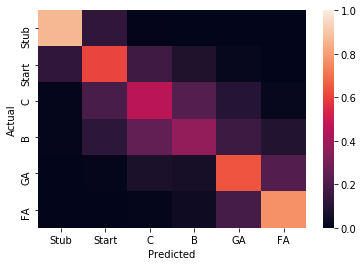

In [42]:
sns.heatmap(confusion_table, vmin=0, vmax=1)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion-matrix.png')
plt.show()

# Fit Final model

In [59]:
pipeline = Pipeline([('preprocessor', RevisionPreprocessor()), ('clf', clone(rnd_results.best_estimator_))])

In [60]:
pipeline.fit(revisions, y)

Pipeline(memory=None,
     steps=[('preprocessor', RevisionPreprocessor()), ('clf', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.125, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=4, objective='multi:softprob',
       random_state=12345, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8))])

In [61]:
with open("../models/xgboost-sequential.pkl", "wb") as f:
    dill.dump(pipeline, f)

# Tree of the Ordinal Model

Graphic of the tree of the ordinal model used in training.

In [ ]:
from graphviz import Digraph

In [ ]:
dot = Digraph(format='png')
dot.node('root', "")
dot.node('stub', 'P(Stub)', shape="rectangle")
dot.node('gtstub', "")
dot.node('start', "P(Start)", shape="rectangle")
dot.node('gtstart', "", )
dot.node('c', 'P(C)', shape="rectangle")
dot.node('gtc', "")
dot.node('b', 'P(B)', shape="rectangle")
dot.node('gtb', "")
dot.node('ga', 'P(GA)', shape="rectangle")
dot.node('fa', 'P(FA)', shape="rectangle")
dot.edge("root", "stub", label="P(Stub)")
dot.edge("root", "gtstub", label="P(X > Stub)")
dot.edge('gtstub', 'start', label="P(Start)")
dot.edge('gtstub', 'gtstart', label="P(X > Start | X > Stub)")
dot.edge('gtstart', 'c', label="P(X = C | X > Start)")
dot.edge('gtstart', 'gtc', label="P(X > C | X > Start)")
dot.edge('gtc', 'b', label="P(X > Start | X > C)")
dot.edge('gtc', 'gtb', label="P(X > Start | X > C)")
dot.edge('gtb', 'ga', label="P(X = GA | X > B)")
dot.edge('gtb', 'fa', label="P(X = FA | X > B)")
print(dot.source)

In [ ]:
dot.render('model.gv', view=True)

# Information on Training Set

In [ ]:
revisions.groupby('wp10')['wp10'].count()

# Check one page

In [ ]:
from wikidit.mw import get_page, Session

In [ ]:
session = Session()
page = get_page(session, "Data science")

In [ ]:
from wikidit.preprocessing import Featurizer
featurizer = Featurizer()

In [ ]:
featurized = featurizer.featurize(page)

In [ ]:
from wikidit.models import predict_page_edits

In [ ]:
import dill
with open("../models/xgboost-sequential.pkl", "rb") as f:
    MODEL = dill.load(f) 